# Using a hybrid approach

We first have to slice the circuit into 3 different parts:
1) The initialization and the QPE
2) The eigenvalue inversion
3) The QPE_dg

Once we have the circuit divided into this three parts we can run them separately (no simultaneously) using different approaches:
- The first and last circuits are run in a noisy simulator (probably with statevectors)
- The second circuit is run in a real QPU (using shots)

To do that, we first have to divide the circuit function into 3 parts so that:
`
qc1.append(qc2.append(qc3))
`
is the full circuit as we already have

In [1]:
import numpy as np
from typing import Optional
from qiskit import QuantumCircuit, QuantumRegister, AncillaRegister, transpile, ClassicalRegister
from qiskit.circuit.library import PhaseEstimation
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev  
from qiskit.circuit.library.arithmetic.exact_reciprocal import ExactReciprocal
from numpy_matrix import NumPyMatrix
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2
from itertools import product
from hhl_functions import *

In [2]:
# Function definition
def init_and_qpe(vector,matrix,tolerance=10e-3):
    # Define the tolerances of the circuit
    epsilon_a = tolerance/6
    epsilon_r = tolerance/3
    epsilon_s = tolerance/3
    
    # We need an np.array to write the values to the register
    if isinstance(vector,(list,np.ndarray)):
        if isinstance(vector,list):
            vector = np.array(vector)    
        # We define the number of needed qubits and insert the vector to the register
        nb = int(np.log2(len(vector)))
        vector_circuit = QuantumCircuit(nb)
        vector_circuit.initialize(vector / np.linalg.norm(vector), list(range(nb)), None)
        # for i in range(nb):
        #     vector_circuit.h(i)
    else:
        raise ValueError(f"Invalid type for vector: {type(vector)}.")
    
    # Define flag, if 1, correct solution, if 0, incorrect
    nf = 1
    
    # Input the matrix A for the QPE
    if isinstance(matrix, (list, np.ndarray)):
        if isinstance(matrix, list):
            matrix = np.array(matrix)

        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Input matrix must be square!")
        
        if np.log2(matrix.shape[0]) % 1 != 0:
            raise ValueError("Input matrix dimension must be 2^n!")
        
        if not np.allclose(matrix, matrix.conj().T):
            raise ValueError("Input matrix must be hermitian!")
        
        if matrix.shape[0] != 2 ** vector_circuit.num_qubits:
            raise ValueError(
                "Input vector dimension does not match input "
                "matrix dimension! Vector dimension: "
                + str(vector_circuit.num_qubits)
                + ". Matrix dimension: "
                + str(matrix.shape[0])
            )
        # We default to a TridiagonalToeplitz matrix, but in a general case we would use a more general library
        # Also, we want the evolution_time to be 2pi/\landa_{max}, but we update it after, when we have the eigenvalues of the matrix
        matrix_circuit = NumPyMatrix(matrix,evolution_time=2 * np.pi, tolerance=epsilon_a)
        
        # General case
        # matrix_circuit = NumPyMatrix(matrix, evolution_time=2 * np.pi)
        
    else:
        raise ValueError(f"Invalid type for matrix: {type(matrix)}.")
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    qf = QuantumRegister(nf,name="flag")  # flag qubits
    qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.append(vector_circuit, qb[:])
    qc.barrier(label="\pi_1")
    # QPE
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    qc.append(phase_estimation, ql[:] + qb[:])
    return qc,nb,nl,matrix_circuit
##########################################################################

def eig_inverse(state,nb,nl,matrix_circuit):
    
    # Define condition and eigenvalue bounds    
    if (hasattr(matrix_circuit, "condition_bounds")):
        kappa = matrix_circuit.condition_bounds()[1]
    else:
        kappa = 1
    # Using kappa, the condition bound,  we define nl, the number of qubits needed to represent the eigenvalues
    nl = max(nb+1,int(np.log2(kappa))+1)
    
    # Define eigenvalues
    if hasattr(matrix_circuit, "eigs_bounds"):
        lambda_min, lambda_max = matrix_circuit.eigs_bounds()
        
        # Constant so that the minimum eigenvalue is represented exactly, since it contributes
        # the most to the solution of the system
        delta = get_delta(nl, lambda_min, lambda_max)
        # Update evolution time
        matrix_circuit.evolution_time = 2 * np.pi * delta / lambda_min
        # Update the scaling of the solution
        scaling = lambda_min
    else:
        delta = 1 / (2 ** nl)
        print("The solution will be calculated up to a scaling factor.")
    
        
    # Define the reciprocal circuit
    
    # # Using an exact reciprocal circuit
    
    reciprocal_circuit = ExactReciprocal(nl, delta)
    # Update number of ancilla qubits
    na = matrix_circuit.num_ancillas
    
    # Construction of the circuit
    
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    if na > 0:
        qa = AncillaRegister(na,name="anc")  # ancilla qubits
    qf = QuantumRegister(1,name="flag")  # flag qubits

    if na > 0:
        qc = QuantumCircuit(qb, ql, qa, qf)
    else:
        qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.initialize(state)
    # Conditioned rotation
    qc.append(reciprocal_circuit, ql[::-1] + [qf[0]])
    
    return qc,scaling

##########################################################################

def inverse_qpe(state,nb,nl,matrix_circuit):
       
    # Initialise the quantum registers
    qb = QuantumRegister(nb,name="b")  # right hand side and solution
    ql = QuantumRegister(nl,name="0")  # eigenvalue evaluation qubits
    qf = QuantumRegister(1,name="flag")  # flag qubits
    qc = QuantumCircuit(qb, ql, qf)

    # State preparation
    qc.initialize(state)
    # QPE inverse
    phase_estimation = PhaseEstimation(nl, matrix_circuit)
    qc.append(phase_estimation.inverse(), ql[:] + qb[:])

    return qc

In [3]:
vector = np.array([1]*4)
matrix = tridiag_matrix(2,-1,4)
qc1,nb,nl,mt_circ=init_and_qpe(vector,matrix)
state = Statevector(qc1)
qc2,_ = eig_inverse(state,nb,nl,mt_circ)
state2 = Statevector(qc2)
test = np.abs(state2)
qc3 = inverse_qpe(state2,nb,nl,mt_circ)
state_f = solution(qc3)
print(state_f)

[0.37728756 0.59804189 0.59804189 0.37728756]


In [4]:
prb = np.linalg.solve(matrix,vector)
prb = prb/np.linalg.norm(prb)
print(prb)

[0.39223227 0.58834841 0.58834841 0.39223227]


As we can see, the solution is mostly the same except the accuracy of the initilization. Now we can begin testing in doing this analyzing the shots in the simulation. If we can achieve this, then we can use this approach in real hardware, described in the next section 

In [42]:
def ampl_from_sim(qc,shots=8192):
    sim = AerSimulator()
    qc.remove_final_measurements()
    qc.measure_all()
    qc = transpile(qc,sim)
    sampler = SamplerV2()
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size

    job = sampler.run([qc],shots=shots)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()

    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]

    prob = []
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

In [43]:
prob = ampl_from_sim(qc2,8192)
qc3 = inverse_qpe(prob,nb,nl,mt_circ)
state_f = solution(qc3)
state_f

array([0.10304055, 0.72467273, 0.66824599, 0.13296385])

If we use shots during the eigenvalue rotation the solution is an estimation based on the probabilities. If we increase the number of shots we should get the true answer. In fact, if the number of shots is defined by $n$ and the approximate and real solution are defined by $|\hat{x}\rangle$ and $|x\rangle$ respectively, then if $n\rightarrow\infty \implies |\hat{x}\rangle=|x\rangle$.

We know in the real Qmio we can use at most 8192 shots. Then, to have a better calculation, we can repeat the inversion multiple times and then average the number of occurrences to get a better estimate.

In [44]:
def ampl_from_qmio(qc:QuantumCircuit,reps=1):
    sim = AerSimulator()
    qc.remove_final_measurements()
    qc.measure_all()
    qc = transpile(qc,sim)
    
    nb = qc.qregs[0].size
    nl = qc.qregs[1].size
    
    sampler = SamplerV2()
    shots = 8192
    counts = {}
    for _ in range(reps):
        job = sampler.run([qc],shots=shots)
        job_result = job.result()
        res=job_result[0].data.meas.get_counts()
        counts = {k: counts.get(k, 0) + res.get(k, 0) for k in set(res) | set(counts)}
    
    all_outcomes = [''.join(outcome) for outcome in product('01', repeat=nb+nl+1)]
    shots= shots*reps
    prob = []
    
    for elem in all_outcomes:
        if elem in counts:
            prob.append(counts[elem]/shots)
        else:
            prob.append(0)
    prob = np.array(prob)
    prob = np.sqrt(prob)
    return prob

In [45]:
prob = ampl_from_qmio(qc2,50)
qc3 = inverse_qpe(prob,nb,nl,mt_circ)
state_f = solution(qc3)
state_f

array([0.41623654, 0.58822168, 0.57630308, 0.38550897])

In [35]:
ampl_from_qmio(qc2,71)

array([0.00898928, 0.01406128, 0.01412228, 0.00927173, 0.02327186,
       0.03317156, 0.03466685, 0.02352902, 0.01812143, 0.03152389,
       0.03055454, 0.0194927 , 0.00981228, 0.0146599 , 0.015625  ,
       0.0108126 , 0.00829289, 0.01540336, 0.01545907, 0.00954583,
       0.13350006, 0.08704571, 0.0866597 , 0.13424494, 0.34970534,
       0.56517574, 0.56632296, 0.34967338, 0.00818857, 0.01215976,
       0.01356337, 0.00849768, 0.        , 0.        , 0.        ,
       0.        , 0.0245307 , 0.02431952, 0.0241065 , 0.02542552,
       0.03513485, 0.05566129, 0.05644345, 0.03491395, 0.00869766,
       0.0137522 , 0.01400001, 0.00869766, 0.01271276, 0.02005782,
       0.02085624, 0.01257679, 0.01534745, 0.01749387, 0.01918151,
       0.01616582, 0.0458365 , 0.0706114 , 0.07167474, 0.04340913,
       0.00849768, 0.01215976, 0.01264496, 0.00829289, 0.        ,
       0.        , 0.        , 0.        , 0.00370869, 0.00507834,
       0.0054063 , 0.00262244, 0.00434883, 0.00718185, 0.00753

#### Time difference in executions

We take the median time to execute for each size. We also get the worst value, to compare approaches

In [46]:
import time
t = np.arange(1, 71, 3)
diff1 = [0]*len(t)
diff2 = [0]*len(t)
time1 = []
time2 = []
for i, elem in enumerate(t):
    print(f'Iteration number {i+1}, the total number of shots are: {elem*8192}')
    tmp = []
    for _ in range(5):
        start = time.time()
        prob = ampl_from_sim(qc2,elem*8192)
        end = time.time()
        tmp.append(end-start)
        qc3 = inverse_qpe(prob,nb,nl,mt_circ)
        state_f = solution(qc3)
        aux = np.linalg.norm(np.abs(state_f-prb))
        if aux > diff1[i]:
            diff1[i] = aux
    time1.append(np.mean(tmp))
    tmp = []
    for _ in range(5):
        start = time.time()
        prob = ampl_from_qmio(qc2,elem)
        end = time.time()
        tmp.append(end-start)
        qc3 = inverse_qpe(prob,nb,nl,mt_circ)
        state_f = solution(qc3)
        aux = np.linalg.norm(np.abs(state_f-prb))
        if aux > diff2[i]:
            diff2[i] = aux
    time2.append(np.mean(tmp))
    
# Print the results 
print(f'The time of the normal simulation is: {time1}')
print(f'The time of the multiple simulation is: {time2}')
print(f'The difference in the first simulation is: {diff1}')
print(f'The difference in the second simulation is: {diff2}')

Iteration number 1, the total number of shots are: 8192
Iteration number 2, the total number of shots are: 32768
Iteration number 3, the total number of shots are: 57344
Iteration number 4, the total number of shots are: 81920
Iteration number 5, the total number of shots are: 106496
Iteration number 6, the total number of shots are: 131072
Iteration number 7, the total number of shots are: 155648
Iteration number 8, the total number of shots are: 180224
Iteration number 9, the total number of shots are: 204800
Iteration number 10, the total number of shots are: 229376
Iteration number 11, the total number of shots are: 253952
Iteration number 12, the total number of shots are: 278528
Iteration number 13, the total number of shots are: 303104
Iteration number 14, the total number of shots are: 327680
Iteration number 15, the total number of shots are: 352256
Iteration number 16, the total number of shots are: 376832
Iteration number 17, the total number of shots are: 401408
Iteration n

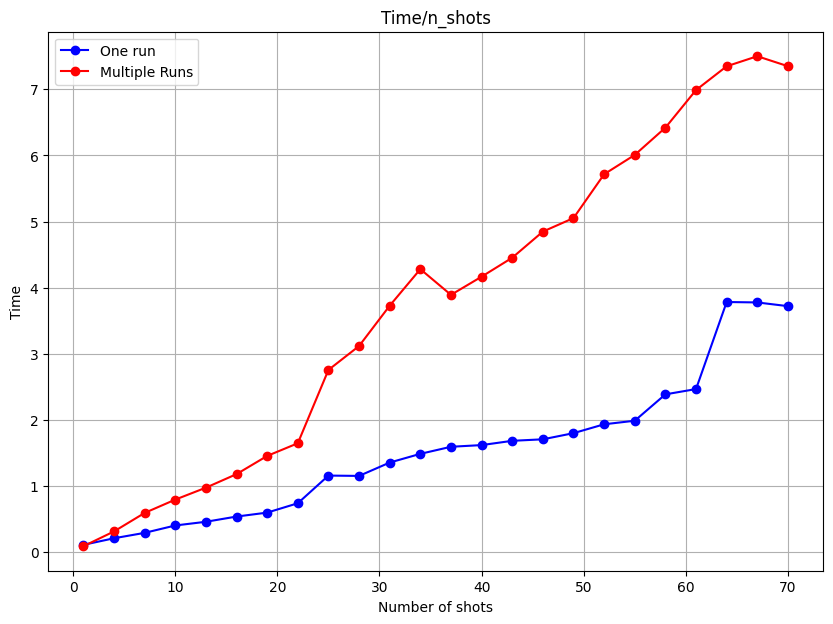

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.plot(t, time1, marker='o', linestyle='-', color='blue')
plt.plot(t, time2, marker='o', linestyle='-', color='red')
plt.xlabel('Number of shots')
plt.ylabel('Time')
plt.title('Time/n_shots')
plt.legend(['One run','Multiple Runs'])
plt.grid(True)
plt.show()

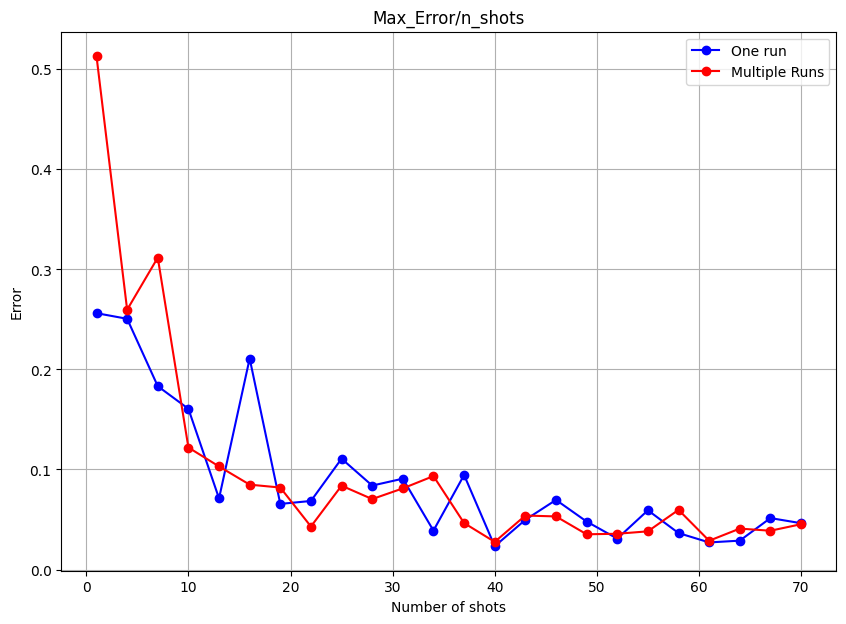

In [49]:
plt.figure(figsize=(10, 7))

plt.plot(t, diff1, marker='o', linestyle='-', color='blue')
plt.plot(t, diff2, marker='o', linestyle='-', color='red')
plt.xlabel('Number of shots')
plt.ylabel('Error')
plt.title('Max_Error/n_shots')
plt.legend(['One run','Multiple Runs'])
plt.grid(True)
plt.show()

Using this results we can experimentally achieve results with an error norm of under $10^{-1}$ or below afer approximately 15 iterations. After that, the result mostly estabilizes. Knowing this, we can use a number of $15/16$ iterations to get good results without barely any loss of efficiency. This means using $131072$ shots.

---

## Test using Qmio

To use this, because of the dependencies of ZMQServer, you must be logged in the CESGA network